In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import warnings 
from sklearn.preprocessing import StandardScaler
from keras.layers import Dense, SimpleRNN
from sklearn.model_selection import KFold, GridSearchCV
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import RandomizedSearchCV
from keras.models import Sequential
from keras.callbacks import EarlyStopping
import tensorflow as tf

df = pd.read_csv('../Data/df_clean.csv',index_col="time")

In [2]:
# Our dependant variables are two variables (generation solar, generation wind onshore). 
# But here, we are just predicting "generation solar"
X = df.drop(columns=['generation solar','generation wind onshore'])
y_solar = df['generation solar']

In [3]:
# Split the data into train and test based on specific time '2017-12-31 23:00:00+00:00'
def split_by_date(X,train_end_date):
    if not isinstance(train_end_date, pd.Timestamp):
        train_end_date = pd.Timestamp(train_end_date)

    # Convert index of X and y to Timestamp objects if they are strings
    if isinstance(X.index[0], str):
        X.index = pd.to_datetime(X.index)
        
    X_train = X[X.index <= train_end_date]
    X_test = X[X.index > train_end_date]
    
    return X_train, X_test

train_end_date = pd.to_datetime('2017-12-31 23:00:00+00:00')
X_train, X_test = split_by_date(X,train_end_date)
y_solar_train, y_solar_test = split_by_date(y_solar, train_end_date)

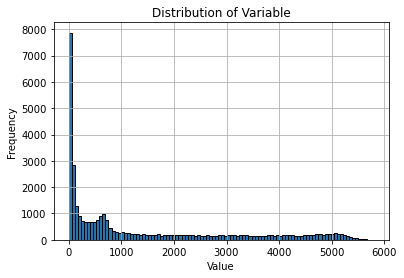

In [12]:
plt.hist(y_solar, bins=100, edgecolor='black')  # Adjust the number of bins as needed
plt.title('Distribution of Variable')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [4]:
scaler_x = StandardScaler()
X_train_scaled = scaler_x.fit_transform(X_train)
X_test_scaled = scaler_x.transform(X_test)

In [5]:
y_solar_train_values = y_solar_train.values
y_solar_test_values = y_solar_test.values

In [6]:
def split_array(X_arr, y_arr, n_past, n_future):
    X, y = list(), list()
    for window_start in range(len(X_arr)):
        past_end = window_start + n_past
        future_end = past_end + n_future
        if future_end > len(X_arr):
            break
        past, future = X_arr[window_start:past_end], y_arr[past_end:future_end]
        X.append(past)
        y.append(future)
    return np.array(X), np.array(y)
        
        

In [8]:
n_past = 24
n_future = 1
X_train_split, y_train_split =split_array(X_train_scaled, y_solar_train_values,n_past,n_future)
test_train24_combine_X = np.concatenate([X_train_scaled[-n_past:],X_test_scaled])
test_train24_combine_y = np.concatenate([y_solar_train_values[-n_past:],y_solar_test_values])
X_test_split, y_test_split = split_array(test_train24_combine_X, test_train24_combine_y , n_past,n_future)

In [9]:
def build_rnn(n_neurons):
    model = Sequential()
    model.add(SimpleRNN(units=n_neurons, activation='tanh', input_shape=(n_past, n_features)))
    model.add(Dense(1, activation='tanh'))
    model.compile(loss='mse',optimizer=tf.keras.optimizers.RMSprop(0.001), metrics=['mse'])
    return model


In [10]:

n_features = X_train.shape[1]
n_neurons = [10, 20, 30]
param_grid = dict(n_neurons=n_neurons)

model_candi = KerasRegressor(build_fn = build_rnn)
grid_rnn = GridSearchCV(model_candi, param_grid, cv=5).fit(X_train_split, y_train_split)


<ipython-input-10-cceb030bb8ae>:5: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead.
  model_candi = KerasRegressor(build_fn = build_rnn)


822/822 [==============================] - 10s 9ms/step - loss: 4954815.0000 - mse: 4954815.0000


In [77]:
best_rnn = grid_rnn.best_estimator_

In [78]:
es = EarlyStopping(monitor='val_loss', mode='min', patience=5)
history_rnn = best_rnn.fit(X_train_split, y_train_split, epochs=50, batch_size=20, validation_split=0.2, callbacks=[es],
                            verbose=0)

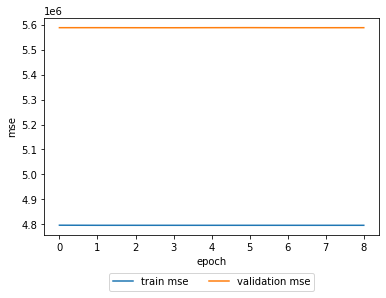

In [79]:
train_mse = history_rnn.history['mse']
valid_mse = history_rnn.history['val_mse']

plt.plot(train_mse, label='train mse')
plt.plot(valid_mse, label='validation mse')
plt.ylabel('mse')
plt.xlabel('epoch')
plt.legend(loc='upper center', bbox_to_anchor=(0.5,-0.15), fancybox=True, shadow=False, ncol=2)

In [51]:
prediction = grid_rnn.predict(X_test_split)

In [69]:
sum((prediction - y_test_split.reshape(-1))**2) // len(y_test_split)

4630906.0

In [53]:
prediction

array([0.99996275, 0.9997198 , 0.99975914, ..., 0.999989  , 0.9999891 ,
       0.99998826], dtype=float32)